# 1. Import stuff

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from typing import *
from qiskit import Aer, QuantumCircuit, execute
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation, AmplitudeEstimationResult
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.boolean_logic import OR

# 2. set the parameter

In [2]:
# number of qubits to represent the uncertainty
num_qubits_A = 3
num_qubits_R = num_qubits_A + 1

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# 3. Construct the NormalDistribution of the stock price
The paper is saying that the stockprice change every step after a log-normal-Distribution. But later it uses a Normal-Distribution

In [3]:
def create_NormalDistribution(num_qubits, S, vol, r, T):
    # resulting parameters for log-normal distribution
    mu = S
    sigma = np.sqrt(T)
    stddev = np.sqrt(sigma)

    # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
    low =  mu - 3 * stddev
    high = mu + 3 * stddev

    # construct A operator for QAE for the payoff function by
    # composing the uncertainty model and the objective
    normal_dist_model = NormalDistribution(
        num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high), name="norm_dist"
    )
    i = len(normal_dist_model.values)//2-1
    strike_price = normal_dist_model.values[i+1]
    return normal_dist_model, strike_price, low, high, sigma

def create_LogNormalDistribution(qubits, S, vol, r, T):
    # resulting parameters for log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
    low = np.maximum(0, mean - 3 * stddev)
    high = mean + 3 * stddev

    # construct A operator for QAE for the payoff function by
    # composing the uncertainty model and the objective
    model = LogNormalDistribution(
        qubits, mu=mu, sigma=sigma**2, bounds=(low, high), name="LogNormalDist"
    )
    i = len(model.values)//2-1
    K = model.values[i]
    return model, K, low, high, stddev

def draw_model(model, strike_price=None, number_of_qubits=0):
    # plot probability distribution
    x = model.values
    y = model.probabilities
    plt.bar(x, y, width=0.2)
    if strike_price != None:
        plt.axvline(x=strike_price, color='red', linestyle='--')
    if len(model.values) < 32:
        plt.xticks(x, size=15, rotation=90)
        plt.yticks(size=15)
    plt.grid()
    plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
    plt.ylabel("Probability ($\%$)", size=15)
    plt.show()
    #plt.savefig('latex/images/probability.png', facecolor='None')
    
def draw_simulate_model(model, strike_price=None):
    # Select the StatevectorSimulator from the Aer provider
    simulator = Aer.get_backend('statevector_simulator')
    # Execute and get counts
    result = execute(model, simulator).result()
    return result
    

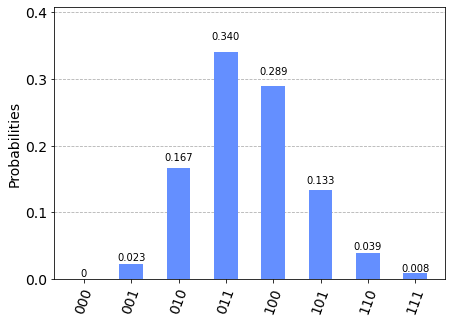

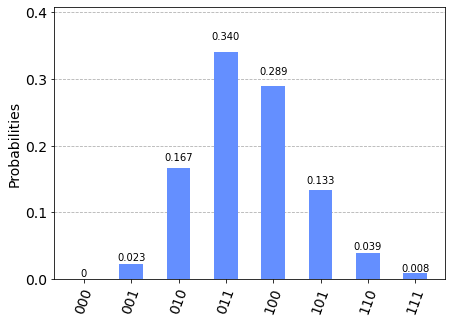

In [4]:
normal_dist_model, strike_price_new, low, high, sigma = create_LogNormalDistribution(num_qubits_A, S, vol, r, T)
if strike_price == None:
    strike_price = strike_price_new
result_normal = draw_simulate_model(normal_dist_model, strike_price)
plot_histogram(result_normal.get_counts())

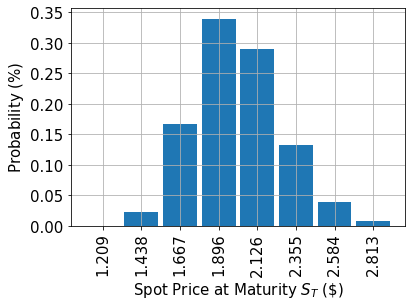

In [5]:
draw_model(normal_dist_model, number_of_qubits=num_qubits_A)

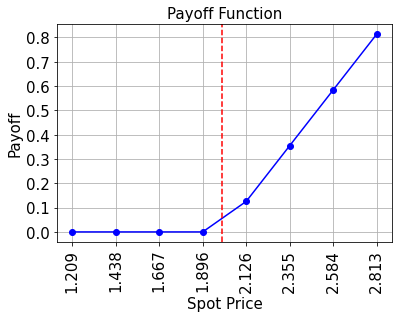

In [6]:
def payoff_european_draw(model, K):
    # plot exact payoff function (evaluated on the grid of the uncertainty model)
    x = model.values
    y = np.maximum(0, x - K)
    plt.plot(x, y, "bo-")
    plt.axvline(x=K, color='red', linestyle='--')
    plt.grid()
    plt.title("Payoff Function", size=15)
    plt.xlabel("Spot Price", size=15)
    plt.ylabel("Payoff", size=15)
    if len(x) < 32:
        plt.xticks(x, size=15, rotation=90)
        plt.yticks(size=15)
    else:
        plt.show()
payoff_european_draw(normal_dist_model, strike_price)

# 4. build R layer to add the payoff function to the circit
The Payoff function is $ f(S_T) = \max\{0,S_T-K\}$
Now we have $A|0^n>$ now we need to build this:
$$
R|x>|0> = |x> \left[\sqrt{1-v\left(x\right)}|0>+\sqrt{v\left(x\right)}|1>\right]
$$

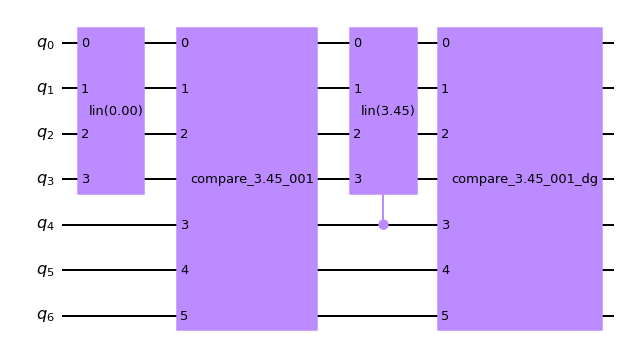

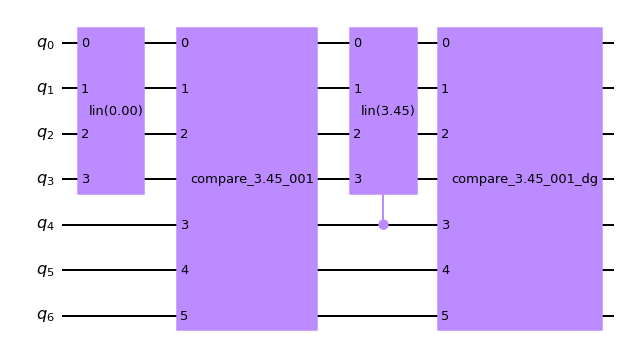

In [7]:
def create_lin_circuit(offset, slope, num_qubits_dist, num_qubits_lini, name="lin-func"):
    linear_model = QuantumCircuit(num_qubits_dist+num_qubits_lini)
    linear_model.ry(offset, num_qubits_dist)
    for j, q_j in enumerate(range(num_qubits_dist)):
        linear_model.cry(slope * pow(2, j), q_j, num_qubits_dist)
    linear_model.name = name
    return linear_model

def value_to_binar(value, num_qubits):
    bin_value = pow(2, num_qubits) - int(np.ceil(value))
    bin_value = f"{bin_value:b}".rjust(num_qubits, "0")
    bin_value = [1 if bin_value[i] == "1" else 0 for i in reversed(range(len(bin_value)))]
    return bin_value


def qubit_integer_comparator(num_qubits_dist, compare_value, bigger_then=True ,name="compare_{value:.2f}_{bit_value}"):
    qubits_dist = list(range(num_qubits_dist))
    qubits_compare = list(range(num_qubits_dist, num_qubits_A*2))
    
    bin_compare_value = value_to_binar(compare_value, num_qubits_dist)
    
    num_qubits_all = num_qubits_dist*2
    num_qubits_compare = len(qubits_compare)
    
    comparator = QuantumCircuit(num_qubits_all)
    if compare_value <= 0:  # condition always satisfied for non-positive values
        if bigger_then:  # otherwise the condition is never satisfied
            comparator.x(qubits_compare[0])
        # condition never satisfied for values larger than or equal to 2^n
    elif compare_value < pow(2, num_qubits_dist):
        if num_qubits_dist > 1:
            for i in range(num_qubits_dist):
                if i == 0:
                    if bin_compare_value[i] == 1:
                        comparator.cx(qubits_dist[i], qubits_compare[i+1])
                elif i < num_qubits_dist - 1:
                    if bin_compare_value[i] == 1:
                        comparator.compose(OR(2), [qubits_dist[i], qubits_compare[i], qubits_compare[i + 1]], inplace=True)
                    else:
                        comparator.ccx(qubits_dist[i], qubits_compare[i], qubits_compare[i + 1])
                else:
                    if bin_compare_value[i] == 1:
                        # OR needs the result argument as qubit not register, thus
                        # access the index [0]
                        comparator.compose(OR(2), [qubits_dist[i], qubits_compare[i], qubits_compare[0]], inplace=True)
                    else:
                        comparator.ccx(qubits_dist[i], qubits_compare[i], qubits_compare[0])

            # flip result bit if geq flag is false
            if not bigger_then:
                comparator.x(qubits_compare[0])

            # uncompute ancillas state
            for i in reversed(range(num_qubits_dist - 1)):
                if i == 0:
                    if bin_compare_value[i] == 1:
                        comparator.cx(qubits_dist[i], qubits_compare[i+1])
                else:
                    if bin_compare_value[i] == 1:
                        comparator.compose(OR(2), [qubits_dist[i], qubits_compare[i], qubits_compare[i+1]], inplace=True)
                    else:
                        comparator.ccx(qubits_dist[i], qubits_compare[i], qubits_compare[i+1])
        else:
            # num_state_qubits == 1 and value == 1:
            comparator.cx(qubits_dist[0], qubits_compare[0])
            # flip result bit if geq flag is false
            if not bigger_then:
                comparator.x(qubits_compare[0])
    else:
        if not bigger_then:  # otherwise the condition is never satisfied
            comparator.x(qubits_compare[0])
    
    
    comparator.name = name.format(value=compare_value, bit_value="".join(str(x) for x in bin_compare_value))
    return comparator

def payoff_european(normal_dist_model, num_qubits_A, low, high, strike_price):
    # calculate the variables
    high_number_qubit = 2**(num_qubits_A)-1
    f_min = 0
    f_max = normal_dist_model.values[-1] - strike_price
    c = 0.25

    breakpoints = [(x-low) / (high-low) * (high_number_qubit) for x in [low, strike_price]]
    slopes_temp = 2 * np.array([0, np.pi/2 * c * (high-low)/high_number_qubit/(f_max-f_min)])
    offsets_temp = np.pi / 4 * (1 - c) * np.ones(len(breakpoints)) + np.pi/2 * c * (-f_min)/(high-low)
    offsets_temp *= 2
    
    slopes = np.zeros_like(slopes_temp)
    for i, slope in enumerate(slopes_temp):
        slopes[i] = slope - sum(slopes[:i])
    offsets = np.zeros_like(offsets_temp)
    for i, (offset, slope, point) in enumerate(zip(offsets_temp, slopes_temp, breakpoints)):
        offsets[i] = offset - slope * point - sum(offsets[:i])

    
    # qubits with the log-normla distribution
    qubits_dist = list(range(num_qubits_A))
    qubits_lini = [num_qubits_A]
    qubits_compare = list(range(num_qubits_A+1, num_qubits_A*2+1))
    num_qubits_all = num_qubits_A*2+1
    num_qubits_lini = len(qubits_lini)
    num_qubits_compare = len(qubits_compare)

    
    payoff_model = QuantumCircuit(num_qubits_all, name="Payoff")
    #print(payoff_model.num_qubits)
    for i, point in enumerate(breakpoints):
        linear_model = create_lin_circuit(offsets[i], slopes[i], num_qubits_A, num_qubits_lini, name="lin({:.2f})".format(point))
        if i == 0 and point == 0:
            payoff_model.append(linear_model.to_gate(), qubits_dist[:] + qubits_lini)
        else:
            comparator = qubit_integer_comparator(num_qubits_A, point)
            payoff_model.append(comparator.to_gate(), qubits_dist[:] + qubits_compare[:])
            payoff_model.append(linear_model.to_gate().control(), [qubits_compare[0]] + qubits_dist[:] + qubits_lini)
            payoff_model.append(comparator.to_gate().inverse(), qubits_dist[:] + qubits_compare[:])
        
    
    
    return payoff_model
european_payoff_model = payoff_european(normal_dist_model, num_qubits_A, low, high, strike_price)
num_total_qubits = european_payoff_model.num_qubits
european_call = QuantumCircuit(num_total_qubits, name="A")
european_call.append(normal_dist_model.to_gate(), range(num_qubits_A))
european_call.append(european_payoff_model.to_gate(), range(num_total_qubits))

# draw the circuit
european_payoff_model.draw("mpl")

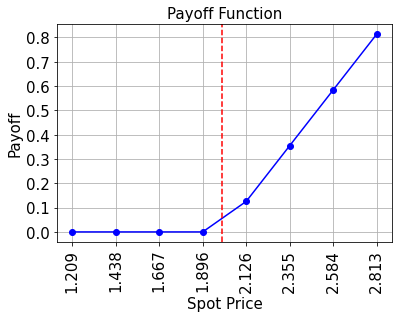

In [8]:
payoff_european_draw(normal_dist_model, strike_price)

# 5. Estimate

In [9]:
def post_processing(scaled_value: float) -> float:
        r"""Map the function value of the approximated :math:`\hat{f}` to :math:`f`.

        Args:
            scaled_value: A function value from the Taylor expansion of :math:`\hat{f}(x)`.

        Returns:
            The ``scaled_value`` mapped back to the domain of :math:`f`, by first inverting
            the transformation used for the Taylor approximation and then mapping back from
            :math:`[0, 1]` to the original domain.
        """
        # revert the mapping applied in the Taylor approximation
        value = scaled_value - 1 / 2 + np.pi / 4 * 0.25
        value *= 2 / np.pi / 0.25

        # map the value from [0, 1] back to the original domain
        value *= high - strike_price - 0
        value += 0

        return value
    
def post_processing2(scaled_value: float) -> float:
        r"""Map the function value of the approximated :math:`\hat{f}` to :math:`f`.

        Args:
            scaled_value: A function value from the Taylor expansion of :math:`\hat{f}(x)`.

        Returns:
            The ``scaled_value`` mapped back to the domain of :math:`f`, by first inverting
            the transformation used for the Taylor approximation and then mapping back from
            :math:`[0, 1]` to the original domain.
        """
        # revert the mapping applied in the Taylor approximation
        value = scaled_value - 1 / 2 + 0.25
        value = value / 0.25

        # map the value from [0, 1] back to the original domain
        value *= high - strike_price - 0
        value += 0
        value = value/2

        return value


In [10]:
def exact_european(model, strike_price):
    # evaluate exact expected value (normalized to the [0, 1] interval)
    x = model.values
    y = np.maximum(0, x - strike_price)
    exact_value = np.dot(model.probabilities, y)
    exact_delta = sum(model.probabilities[x >= strike_price])
    return exact_value, exact_delta

def estimated_european(num_uncertainty_qubits, european_call, post_processing_func=post_processing, epsilon=0.01, alpha=0.05, shots=100):

    qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=shots)
    problem = EstimationProblem(
        state_preparation=european_call,
        objective_qubits=[num_uncertainty_qubits],
        post_processing=post_processing_func,
    )
    # construct amplitude estimation
    ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    result = ae.estimate(problem)

    conf_int = np.array(result.confidence_interval_processed)
    return result, conf_int

In [11]:
exact_value, exact_delta = exact_european(normal_dist_model, strike_price)

Exact value:        	0.1133
Estimated value:    	0.1174
Confidence interval:	[0.1124, 0.1224]


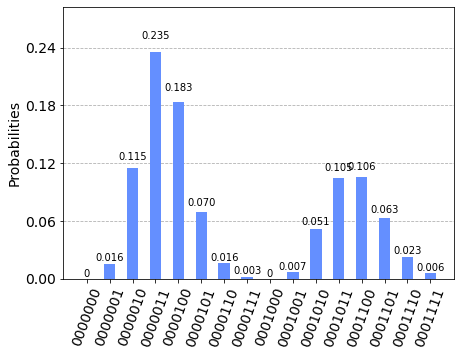

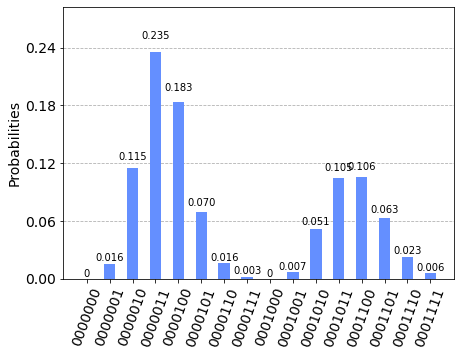

In [12]:
#my result
result, conf_int = estimated_european(num_qubits_A, european_call)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))
#result, conf_int = estimated_european(num_qubits_A, european_call, post_processing2)
#print("Estimated value:    \t%.4f" % (result.estimation_processed))
#print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))
result = draw_simulate_model(european_call)
plot_histogram(result.get_counts())

## Grover Operator

Grover's search algorithm [1, 2] consists of repeated applications of the so-called
Grover operator used to amplify the amplitudes of the desired output states.
This operator, $\mathcal{Q}$, consists of the phase oracle, $ \mathcal{S}_f $,
zero phase-shift or zero reflection,$ \mathcal{S}_0 $, and an
input state preparation $ \mathcal{A} $:

$$        \mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f $$

In the standard Grover search we have $ \mathcal{A} = H^{\otimes n} $:

$$
        \mathcal{Q} = H^{\otimes n} \mathcal{S}_0 H^{\otimes n} \mathcal{S}_f
                    = D \mathcal{S_f}
$$
The operation $ D = H^{\otimes n} \mathcal{S}_0 H^{\otimes n} $ is also referred to as
diffusion operator. In this formulation we can see that Grover's operator consists of two
steps: first, the phase oracle multiplies the good states by -1 (with  $ \mathcal{S}_f $)
and then the whole state is reflected around the mean (with $ D $).

This class allows setting a different state preparation, as in quantum amplitude
amplification (a generalization of Grover's algorithm), $ \mathcal{A} $ might not be
a layer of Hardamard gates [3].

The action of the phase oracle $ \mathcal{S}_f $ is defined as

$$
        \mathcal{S}_f: |x\rangle \mapsto (-1)^{f(x)}|x\rangle
$$

where  $ f(x) = 1 $ if $ x $ is a good state and 0 otherwise. To highlight the fact
that this oracle flips the phase of the good states and does not flip the state of a result
qubit, we call $ \mathcal{S}_f $ a phase oracle.

Note that you can easily construct a phase oracle from a bitflip oracle by sandwiching the
controlled X gate on the result qubit by a X and H gate.

The zero reflection $ \mathcal{S}_0 $ is usually defined as
$$ \mathcal{S}_0 = 2 |0\rangle^{\otimes n} \langle 0|^{\otimes n} - \mathbb{I}_n $$
where $ \mathbb{I}_n $ is the identity on $ n $ qubits.
By default, this class implements the negative version 
$ 2 |0\rangle^{\otimes n} \langle 0|^{\otimes n} - \mathbb{I}_n$, since this can simply
    be implemented with a multi-controlled Z sandwiched by X gates on the target qubit and the
    introduced global phase does not matter for Grover's algorithm.

In [13]:
from qiskit.circuit import AncillaRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate

In [16]:
def grover_operator_oracle(num_qubits:int, num_ancillas:int, objective_qubits:List[int]) -> QuantumCircuit:
    # build the reflection about the bad state (zero Reflection): a MCZ with open controls (thus X gates
        # around the controls) and X gates around the target to change from a phaseflip on
        # |1> to a phaseflip on |0>
        num_state_qubits = num_qubits - num_ancillas

        oracle = QuantumCircuit(num_state_qubits, name="S_f")
        oracle.h(objective_qubits[-1])
        if len(objective_qubits) == 1:
            oracle.x(objective_qubits[0])
        else:
            oracle.mcx(objective_qubits[:-1], objective_qubits[-1])
        oracle.h(objective_qubits[-1])

        return oracle

In [17]:
def zero_reflection(num_qubits: int, num_ancillas: int, reflection_qubits: list[int], mcx_mode: str) -> QuantumCircuit:
#    qr_state = QuantumRegister(num_qubits - num_ancillas)
    reflection = QuantumCircuit(num_qubits - num_ancillas, name="S_0")

    if num_ancillas > 0:
        qr_ancilla = AncillaRegister(num_ancillas, "ancilla")
        reflection.add_register(qr_ancilla)
    else:
        qr_ancilla = []

    reflection.x(reflection_qubits)
    if len(reflection_qubits) == 1:
        reflection.z(0)  # MCX does not allow 0 control qubits, therefore this is separate
    else:
        reflection.h(reflection_qubits[-1])
        reflection.mcx(reflection_qubits[:-1], reflection_qubits[-1], qr_ancilla[:], mode=mcx_mode)
        reflection.h(reflection_qubits[-1])
    reflection.x(reflection_qubits)

    return reflection

TypeError: 'type' object is not subscriptable

In [18]:
def grover_operator(num_qubits: int, num_ancillas: int, oracle: QuantumCircuit, zero_reflections: QuantumCircuit, state_preparation: QuantumCircuit,
                    reflection_qubits:int, objective_qubits: list[int],
                    insert_barriers: bool) -> QuantumCircuit :
        num_state_qubits = num_qubits - num_ancillas
        circuit = QuantumCircuit(num_state_qubits, name="Q")
        #not needed since 0
        #if num_ancillas > 0:
        #    circuit.add_register(AncillaRegister(num_ancillas, name="ancilla"))

        circuit.append(oracle.to_gate(), list(range(num_qubits)))
        if insert_barriers:
            circuit.barrier()
        circuit.append(
            state_preparation.inverse().to_gate(),
            list(range(num_qubits))
        )
        if insert_barriers:
            circuit.barrier()
        circuit.append(
            zero_reflections.to_gate(), list(range(num_qubits))
        )
        if insert_barriers:
            circuit.barrier()
        circuit.append(
            state_preparation.to_gate(), list(range(num_qubits))
        )

        # minus sign
        circuit.global_phase = np.pi

        #circuit.add_register(*circuit.qregs)
        
        return circuit

TypeError: 'type' object is not subscriptable

In [ ]:
num_qubits = 7
num_ancilla = 0
# qubits die für S_0 genutzt werden sollen
reflection_qubits = list(range(num_qubits - num_ancilla))
# qubit, das für S_f genutzt und dessen Amplitude gefunden werden soll.
objective_qubits = [3]
mcx_mode = "noancilla"


state_preparation = european_call
oracle = grover_operator_oracle(num_qubits ,num_ancilla, objective_qubits)
zero_reflections = zero_reflection(num_qubits, num_ancilla, reflection_qubits, mcx_mode)
custom_grover_operator = grover_operator(num_qubits, num_ancilla, oracle, zero_reflections,
                                  state_preparation, reflection_qubits,objective_qubits, False)
# set usage of barriers to False since otherwise code crashes when grover_operatos.to_gate() is executed
custom_grover_operator.decompose().draw("mpl", style="iqx")

## Canonical AE

### Custom Canonical AE

In [ ]:
def construct_circuit(
        m: int, estimation_problem: EstimationProblem, measurement: bool = False
    ) -> QuantumCircuit:
        """Construct the Amplitude Estimation quantum circuit.

        Args:
            estimation_problem: The estimation problem for which to construct the QAE circuit.
            measurement: Boolean flag to indicate if measurements should be included in the circuit.
            m: Number of Qubits for PE

        Returns:
            The QuantumCircuit object for the constructed circuit.
        """
        from qiskit.circuit.library import PhaseEstimation
        # do not provide qft
        pec = PhaseEstimation(m, estimation_problem.grover_operator.to_gate())

        # combine the Phase Estimation circuit with the A operator
        #circuit = QuantumCircuit(*pec.qregs)
        circuit.append(
            estimation_problem.state_preparation.to_gate(),
            list(range(m, circuit.num_qubits)),
        )
        circuit.append(pec,list(range(m)))

        # add measurements if necessary
        if measurement:
            cr = ClassicalRegister(m)
            circuit.add_register(cr)
            circuit.measure(list(range(m)), list(range(m)))

        return circuit

In [ ]:
#https://qiskit.org/documentation/_modules/qiskit/algorithms/amplitude_estimators/ae.html#AmplitudeEstimation
def evaluate_count_results(m,counts):
        # construct probabilities
        measurements = OrderedDict()
        samples = OrderedDict()
        shots = self._quantum_instance._run_config.shots

        for state, count in counts.items():
            y = int(state.replace(" ", "")[: m][::-1], 2)
            probability = count / shots
            measurements[y] = probability
            a = np.round(np.power(np.sin(y * np.pi / 2**m), 2), decimals=7)
            samples[a] = samples.get(a, 0.0) + probability

        return samples, measurements

In [ ]:
def evaluate_statevector_results(m, statevector):
        # map measured results to estimates
        M = 2**3
        measurements = OrderedDict()  # type: OrderedDict
        num_qubits = int(np.log2(len(statevector)))
        for i, amplitude in enumerate(statevector):
            b = bin(i)[2:].zfill(num_qubits)[::-1]
            y = int(b[: m], 2)  # chop off all except the evaluation qubits
            measurements[y] = measurements.get(y, 0) + np.abs(amplitude) ** 2

        samples = OrderedDict()  # type: OrderedDict
        for y, probability in measurements.items():
            if y >= int(M / 2):
                y = M - y
            # due to the finite accuracy of the sine, we round the result to 7 decimals
            a = np.round(np.power(np.sin(y * np.pi / 2**m), 2), decimals=7)
            samples[a] = samples.get(a, 0) + probability

        return samples, measurements

In [ ]:
 def evaluate_measurements(
        m: int,
        circuit_results,
        threshold: float = 1e-6,
    ) -> tuple[dict[int, float], dict[float, float]]:
        """Evaluate the results from the circuit simulation.

        Given the probabilities from statevector simulation of the QAE circuit, compute the
        probabilities that the measurements y/gridpoints a are the best estimate.

        Args:
            circuit_results: The circuit result from the QAE circuit. Can be either a counts dict
                or a statevector.
            threshold: Measurements with probabilities below the threshold are discarded.

        Returns:
            Dictionaries containing the a gridpoints with respective probabilities and
                y measurements with respective probabilities, in this order.
        """
        # compute grid sample and measurement dicts
        if isinstance(circuit_results, dict):
            samples, measurements = evaluate_count_results(m, circuit_results)
        else:
            samples, measurements = evaluate_statevector_results(m, circuit_results)

        # cutoff probabilities below the threshold
        samples = {a: p for a, p in samples.items() if p > threshold}
        measurements = {y: p for y, p in measurements.items() if p > threshold}

        return samples, measurements

In [ ]:
m = 3
M = 2**m
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)

problem = EstimationProblem(
    state_preparation=european_call,
    grover_operator = custom_grover_operator,
    objective_qubits=[3],
    post_processing=post_processing,
)

In [ ]:
def estimate(m, estimation_problem: EstimationProblem, qi) -> "AmplitudeEstimationResult":
        """Run the amplitude estimation algorithm on provided estimation problem.

        Args:
            estimation_problem: The estimation problem.

        Returns:
            An amplitude estimation results object.

        Raises:
            ValueError: If `state_preparation` or `objective_qubits` are not set in the
                `estimation_problem`.
        """
        # check if A factory or state_preparation has been set
        quantum_instance = qi
        if estimation_problem.state_preparation is None:
            raise ValueError(
                "The state_preparation property of the estimation problem must be set."
            )

        if estimation_problem.objective_qubits is None:
            raise ValueError("The objective_qubits property of the estimation problem must be set.")

        result = AmplitudeEstimationResult()
        result.num_evaluation_qubits = m
        result.post_processing = estimation_problem.post_processing

        # should not be called
        if quantum_instance.is_statevector:
            print('hihi')
            circuit = construct_circuit(m, estimation_problem, measurement=False)
            # run circuit on statevector simulator
            statevector = quantum_instance.execute(circuit).get_statevector()
            result.circuit_results = statevector

            # store number of shots: convention is 1 shot for statevector,
            # needed so that MLE works!
            result.shots = 1
        else:
            # run circuit on QASM simulator
            circuit = construct_circuit(m, estimation_problem, measurement=True)
            counts = quantum_instance.execute(circuit).get_counts()
            result.circuit_results = counts

            # store shots
            result.shots = sum(counts.values())
        print(results)
        samples, measurements = evaluate_measurements(m, result.circuit_results)

        result.samples = samples
        result.samples_processed = {
            estimation_problem.post_processing(a): p for a, p in samples.items()
        }
        result.measurements = measurements

        # determine the most likely estimate
        result.max_probability = 0
        for amplitude, (mapped, prob) in zip(samples.keys(), result.samples_processed.items()):
            if prob > result.max_probability:
                result.max_probability = prob
                result.estimation = amplitude
                result.estimation_processed = mapped

        # store the number of oracle queries
        result.num_oracle_queries = result.shots * (M - 1)
        
        # only check estimation for custom AE
        # run the MLE post processing
        mle = 0
        result.mle = mle
        result.mle_processed = estimation_problem.post_processing(mle)

        result.confidence_interval = self.compute_confidence_interval(result)
        result.confidence_interval_processed = tuple(
           estimation_problem.post_processing(value) for value in result.confidence_interval
        )

        return result

In [ ]:
custom_estimate = estimate(m, problem, qi)

### Qiskit Canonical AE

In [ ]:
ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=qi,
)

In [ ]:
ae_result = ae.estimate(problem)

In [ ]:
print(ae_result.estimation_processed)
print("Interpolated MLE estimator:", ae_result.mle_processed)

In [ ]:
conf_int = np.array(ae_result.confidence_interval)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (ae_result.estimation_processed))
print("95 Percent Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Something is wrong with confidence interval here. Mean(Estimated value) does not lie in interval.
Check post_processing and how interval and estimation is calculated

In [ ]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples_processed.keys())
probabilities = list(ae_result.samples_processed.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(exact_value, color="r", ls="--")
plt.axvline(ae_result.mle_processed, color="g", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [ ]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl")  # decompose 1 level: exposes the Phase estimation circuit!

### Iterative AE

In [ ]:
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)


# Without custom grover_operator code would crash thanks to .to_gate() calls 
problem = EstimationProblem(
    state_preparation=european_call,
    grover_operator = custom_grover_operator,
    objective_qubits=[3],
    post_processing=post_processing,
)

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [ ]:
result = ae.estimate(problem)

In [ ]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("95 Percent Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
result.samples

In [ ]:
#TODO check how to plot result
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(result.samples_processed.keys())
probabilities = list(result.samples_processed.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(exact_value, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()